In [1]:
# KoBART summarization Model

import torch
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# huggingface에 이미 학습이 된 모델과 tokenizer를 불러옴
tokenizer = PreTrainedTokenizerFast.from_pretrained('digit82/kobart-summarization')
model = BartForConditionalGeneration.from_pretrained('digit82/kobart-summarization')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [ ]:
# 처리할 파일의 이름
file_name = '2024_매일경제'

In [2]:
import pandas as pd

curr_df = pd.read_csv(f'../content/cleaned_{file_name}.csv')

In [ ]:
curr_df.shape

(3315, 13)

In [ ]:
curr_df.head()

,Unnamed: 0,index,link,date,title,body,year,month,day,hour,minute,cleaned_title,cleaned_body
0,0,2024000001,https://n.news.naver.com/mnews/article/009/000...,2024-01-01 00:14:00,“해외서 세금아끼면 국내서 토해내라”…삼성 등 300곳 ‘최저한세 폭탄’,[사진=연합뉴스]올해부터 주요국 다국적기업에 최소 15%의 법인세를 매기는 글로벌 ...,2024,1,1,0,14,해외서 세금 아끼면 국내서 토해내라 삼성 300곳 최저한세 폭탄,올해부터 주요국 다국적 기업에 최소 15의 법인세를 매기는 글로벌 최저한세가 시행된...
1,1,2024000002,https://n.news.naver.com/mnews/article/009/000...,2024-01-01 08:17:00,“8만 전자? 9만 전자까지 가야죠”…삼성 ‘신무기’ 뭐가 특별하길래 [위클리반도체],만약 반도체에도 연예계처럼 연말 시상식이 있다면 아마 올해 메모리 분야 대상은 만장...,2024,1,1,8,17,8만 9만 전자까지 가야죠 삼성 신무기 뭐가 특별하길래,반도체에도 연예계처럼 연말 시상식이 있다면 아마 올해 메모리 분야 대상은 만장일치로...
2,2,2024000003,https://n.news.naver.com/mnews/article/009/000...,2024-01-01 10:36:00,‘미등기’ 대기업 총수 4명 보수 356억원…가장 많이 받은 회장님은,"이재현 CJ회장, 2022년 221억원 1위신동빈, 이명희, 김승연 회장 등 뒤이어...",2024,1,1,10,36,미등기 대기업 총수 4명 보수 356억 원 가장 많이 받은 회장님은,이재현 회장 2022년 221억 원 1위 신동빈 이명희 김승연 회장 뒤 이어 정용진...
3,3,2024000004,https://n.news.naver.com/mnews/article/009/000...,2024-01-01 13:42:00,“올해도 주식 ‘될놈될’ 예상…이 ETF로 반도체·2차전지 한 방에 투자하세요” [...,TIGER 코리아테크액티브 ETF반도체·2차전지 등 기술주 투자전문가가 직접 주도업...,2024,1,1,13,42,올해도 주식 될 놈될 예상이로 반도체 2차 전지 한 방에 투자하세요,코리아 테크 액티브 반도체 2차 전지 기술주 투자 전문가가 직접 주도 업종 선별 특...
4,4,2024000005,https://n.news.naver.com/mnews/article/009/000...,2024-01-01 16:12:00,메모리 '훈풍'…D램 가격 더 오를 듯,반도체국내 반도체 기업들은 2024년 본격적인 반등을 기대하고 나섰다. 사진은 삼성...,2024,1,1,16,12,메모리 훈풍램 가격 더 오를 듯,반도체 국내 반도체 기업들은 2024년 본격적인 반 등을 기대하고 나섰다 사진은 삼...


23923


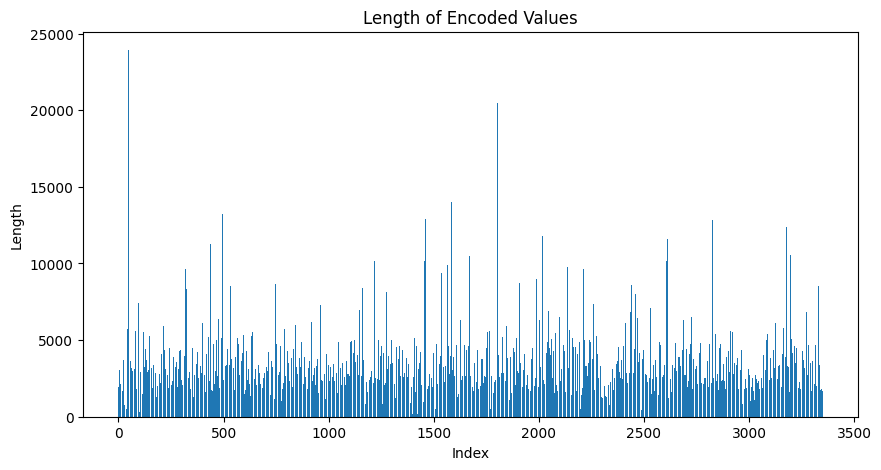

In [7]:
import matplotlib.pyplot as plt

encoded_values = curr_df['body'].dropna().apply(lambda x: x.encode('utf-8') if isinstance(x, str) else None).tolist()

length = []

for value in encoded_values:
    length.append(len(value))

print(max(length))

plt.figure(figsize=(10, 5))
plt.bar(range(len(length)), length)
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Length of Encoded Values')
plt.show()

In [8]:
# 요약 모델을 포함한 함수 -> 이 함수를 사용하면 본문이 요약됨

def summarizer(text):
    # 문서를 토큰화(encode해줌)
    raw_input_ids = tokenizer.encode(text)
    # 입력을 넣어줄때 맨 앞에 bos토큰, 맨 뒤에 eos토큰을 추가하여 모델이 입력단위를 알아보게 함
    input_ids = [tokenizer.bos_token_id] + raw_input_ids + [tokenizer.eos_token_id]

    # 요약 : 모델 추론과정
    summarized_ids = model.generate(torch.tensor([input_ids]),
                                    num_beams=4,
                                    max_length=1024) # 이건 설정 나중에 해보자..
    # 토큰을 다시 인간이 알아볼 수 있는 자연어로 decode해줌
    summarized_text = tokenizer.decode(summarized_ids.squeeze().tolist(),
                                       skip_special_tokens=True)

    return summarized_text

In [9]:
# curr_df['cleaned_body']의 value들을 요약하여 curr_df['summarized_body']로 추가
curr_df['summarized_body'] = curr_df['cleaned_body'].apply( summarizer )

KeyboardInterrupt: 

In [ ]:
curr_df.to_csv(f'summarized_{file_name}.csv',
               index=False,
               encoding='utf-8')